## 2. Order prices

What’s the average order value? Does Olist process transactions involving items with extremely low or high prices? Before addressing these questions, let’s take a closer look at the order_items table. This table includes various IDs along with the price and shipping cost of each item in an order. The currency used is the Brazilian real.

Let's answer our first question then: What's the average order value, considering both the cost of products and shipping? To start, let's find the orders with the lowest and the highest costs:

In [2]:
import sqlite3
import pandas as pd
db_path = '/content/drive/MyDrive/Olist E-Commerce/olist.sqlite'
db_connection = sqlite3.connect(db_path)

In [3]:
order_price_stats = """
SELECT
    MIN(order_price) AS min_order_price,
    ROUND(AVG(order_price), 2) AS avg_order_price,
    MAX(order_price) AS max_order_price
FROM (
    SELECT
        orders.order_id,
        SUM(order_items.price + order_items.freight_value) AS order_price
    FROM orders
        JOIN order_items USING (order_id)
    GROUP BY orders.order_id
)
"""

pd.read_sql_query(order_price_stats, db_connection)

,min_order_price,avg_order_price,max_order_price
0,9.59,160.58,13664.08


## 2.2 Product cost and shipping cost

The average order price is 160.58 BRL, as we can see, the most expensive order is 13664.08, almost 100 times the average, meaning we probably have a right-tailed distribution, where most of the orders have low cost but there are orders with a very high cost. Let's see the variation in prices, this time separating product cost and shipping cost. To start, let's aggregate the product cost and shipping cost for each order:

In [4]:
order_product_and_shipping_costs = """
SELECT
    orders.order_id,
    SUM(price) AS product_cost,
    SUM(freight_value) AS shipping_cost
FROM
    orders
    JOIN order_items USING (order_id)
WHERE order_status = 'delivered'
GROUP BY orders.order_id
"""

df = pd.read_sql_query(order_product_and_shipping_costs, db_connection)
df

,order_id,product_cost,shipping_cost
0,00010242fe8c5a6d1ba2dd792cb16214,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90,18.14
...,...,...,...
96473,fffc94f6ce00a00581880bf54a75a037,299.99,43.41
96474,fffcd46ef2263f404302a634eb57f7eb,350.00,36.53
96475,fffce4705a9662cd70adb13d4a31832d,99.90,16.95
96476,fffe18544ffabc95dfada21779c9644f,55.99,8.72


### Visualization

Let's plot a histogram of each cost. Since the cost can take a huge range of values but most orders have a low cost, I'll limit each plot's x-axes to 500 reals and 80 reals respectively to highlight the distribution of the most common values:

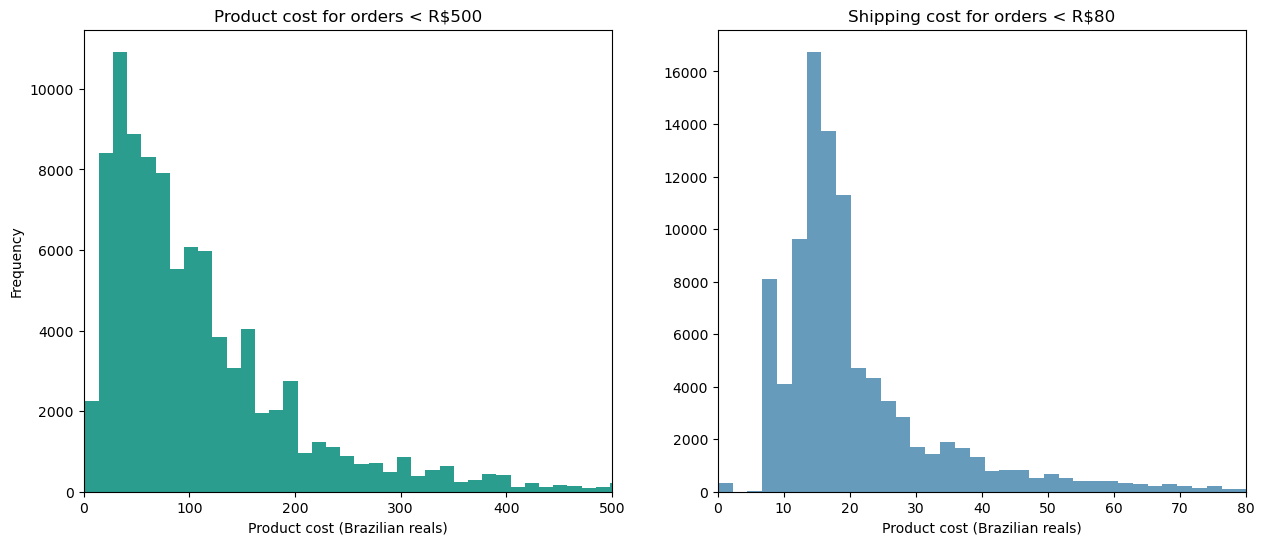

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
# Histogram for total product cost
plt.subplot(1, 2, 1)
plt.hist(df['product_cost'], bins=1000, color='#2A9D8F')
plt.title('Product cost for orders < R$500')
plt.xlabel('Product cost (Brazilian reals)')
plt.ylabel('Frequency')
plt.xlim([0, 500])
# Histogram for total shipping cost
plt.subplot(1, 2, 2)
plt.hist(df['shipping_cost'], bins=800, color='#669BBC')
plt.title('Shipping cost for orders < R$80')
plt.xlabel('Product cost (Brazilian reals)')
plt.xlim([0, 80])
plt.show()